<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Run-Simulation-Study" data-toc-modified-id="Run-Simulation-Study-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Run Simulation Study</a></span></li><li><span><a href="#References" data-toc-modified-id="References-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>References</a></span></li></ul></div>

This is a simulation for M/D/1 queues as for example in an automated car wash.

# Load Libraries

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import random

import simpy

In [2]:
def poissonPlot(data, title=None):
    μ = data.mean()
    n = data.count()
    max = math.ceil(data.max()/10)*10
    
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    
    ax = fig.gca()
    ax.set_xlim(0, max)
    
    if title!=None:
        ax.set_title(title+" (n={:,})".format(n))
        
    data.hist(ax=ax, bins=max+1, density=True)

    x = [ i/10 for i in range(1, 10*max)]
    y = [ 1/μ*math.exp(-x/μ) for x in x]
    plt.plot(x, y, lw=3, color='red')
    ax.axvline(x=μ, color='red')
    plt.text(μ+0.2,0.9*y[0],'μ='+'%2.2f' % μ, color='red', fontsize=14)
    plt.grid(True)

# Run Simulation Study

In [3]:
def MD1(IARR, PROC, N, log=False, plot=False):
    cd = pd.DataFrame()
    cd['iarr'] = [ random.expovariate(1.0/IARR) for i in range(N) ]
    
    cd['proc'] = [ PROC for i in range(N) ]      ##############################
    
    # Prepare a DataFrame to record observations
    sd = pd.DataFrame()
    sd['arrived at'] = [None]*N
    sd['proc started at'] = [None]*N
    sd['proc finished at'] = [None]*N 
    
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=1)
    
    # initialise variables describing the queue
    maxql=0  # maximum length of queue
    qt=0     # "integral" of ql from 0 to lastT
    lastT=0 # last time qt was updated
    
    # initialise variables describing the server
    maxs=0   # max number of customers served at anyone time
    s=0      # current number of customers being served
    st=0     # "integral" of s from 0 to env.now
    
    def source(n):
        # generate the customers.
        for i in range(n):
            # wait until the next customer arrives...
            yield env.timeout(cd.at[i, 'iarr'])
            c = customer(i)
            env.process(c)
     
    def customer(i):
        sd.at[i, 'arrived at'] = env.now
        
        nonlocal qt, lastT, maxql, s, st, maxs
        
        # length of the queue before the customer enters

        ql = len(counter.queue) 
        if ql==maxql:
            maxql = ql+1
        qt += ql*(env.now-lastT)
        lastT=env.now

        req = counter.request()
        # Wait for the counter 
        
        yield req
        
        # length of the queue just before the customer leaves
        ql = len(counter.queue) +1
        qt += ql*(env.now-lastT)
        lastT=env.now
        
        sd.at[i, 'proc started at'] = env.now
        # Wait while the clerk is dealing with you
        
        s += 1
        if s>maxs:
            maxs = s
            
        proc = cd.at[i, 'proc']
        yield env.timeout(proc)
        sd.at[i, 'proc finished at'] = env.now
        counter.release(req)
        
        s -= 1
        st += proc
        
            
    env.process(source(N))
    env.run()
    
    sd['wait time']=sd['proc started at']-sd['arrived at'] 
    sd['proc time']=sd['proc finished at']-sd['proc started at']
    sd['flow time']=sd['proc finished at']-sd['arrived at']
    
    sd['idle time']=sd['proc started at']-sd['proc finished at'].shift(1)
    sd.at[0, 'idle time']=sd.at[0, 'proc started at']
    
    sd['idep']=sd['proc finished at']-sd['proc finished at'].shift(1)
    sd.at[0, 'idep']=sd.at[0, 'proc finished at']
    
    w = sd['wait time']
    f = sd['flow time']
    
    if plot:
        poissonPlot(cd['iarr'], "Inter-Arrival Times")
        poissonPlot(sd['wait time'], "Wait Times")
        poissonPlot(sd['flow time'], "Flow Times")
        poissonPlot(sd['idep'], "Inter-Departure Times")
        
        
    if log:
        μ_iarr = cd['iarr'].mean()
        μ_proc = cd['proc'].mean()
        ρ = st/lastT
        ρ_theor = PROC/IARR
        Lq = qt/lastT
  
        print(f"   actual / expected   N={N:,d}")
        print(f"a= {μ_iarr:6.2f}   {IARR:6.2f}   (Inter Arrival Time)")
        print(f"p= {μ_proc:6.2f}   {PROC:6.2f}   (Processing Time)")
        print(f"ρ= {100*ρ:5.1f}%  {100*ρ_theor:6.1f}%   (System Utilisation)")
        print(f"L= {ρ+Lq:6.2f}   {ρ_theor+1/2*ρ_theor**2/(1-ρ_theor):6.2f}   (inventory in the system)")
        print(f"Lq={Lq:6.2f}   {1/2*ρ_theor**2/(1-ρ_theor):6.2f}   (inventory in the queue)")
        print(f"Ls={ρ:6.2f}   {ρ_theor:6.2f}   (inventory in service)")
        print(f"W= {f.mean():6.2f}   {PROC+PROC/2*ρ_theor/(1-ρ_theor):6.2f}   (Flow Time through the System")
        print(f"Wq={w.mean():6.2f}   {PROC/2*ρ_theor/(1-ρ_theor):6.2f}   (Wait Time)")
        print(f"Ws={μ_proc:6.2f}   {PROC:6.2f}   (Service Time)")
        print()
        
    return w.mean(), w.max(), qt/lastT, maxql, st/lastT

In [4]:
random.seed(41)
wavg, wmax, qavg, qmax, util =MD1(4,3,1000, log=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

   actual / expected   N=1,000
a=   4.10     4.00   (Inter Arrival Time)
p=   3.00     3.00   (Processing Time)
ρ=  73.0%    75.0%   (System Utilisation)
L=   1.58     1.88   (inventory in the system)
Lq=  0.85     1.12   (inventory in the queue)
Ls=  0.73     0.75   (inventory in service)
W=   6.48     7.50   (Flow Time through the System
Wq=  3.48     4.50   (Wait Time)
Ws=  3.00     3.00   (Service Time)

Max Wq= 18.98  
Max Lq=  7  


   actual / expected   N=1,000
a=   4.22     4.00   (Inter Arrival Time)
p=   3.00     3.00   (Processing Time)
ρ=  71.1%    75.0%   (System Utilisation)
L=   1.57     1.88   (inventory in the system)
Lq=  0.86     1.12   (inventory in the queue)
Ls=  0.71     0.75   (inventory in service)
W=   6.63     7.50   (Flow Time through the System
Wq=  3.63     4.50   (Wait Time)
Ws=  3.00     3.00   (Service Time)

Max Wq= 28.29  
Max Lq= 10  


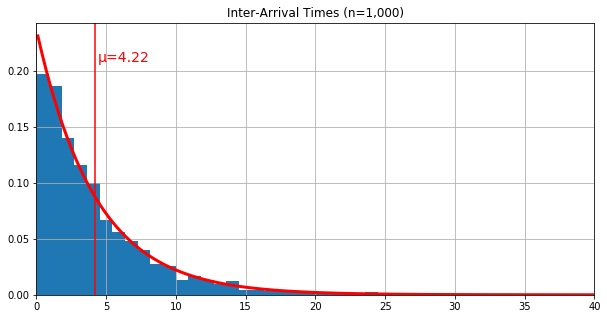

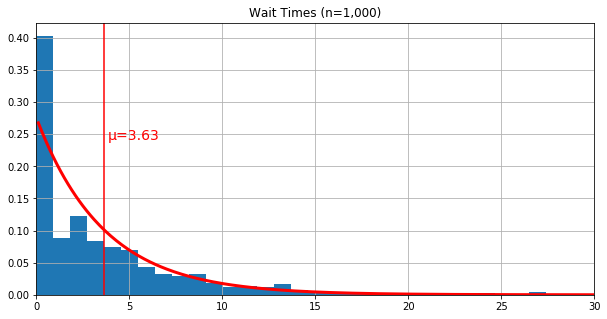

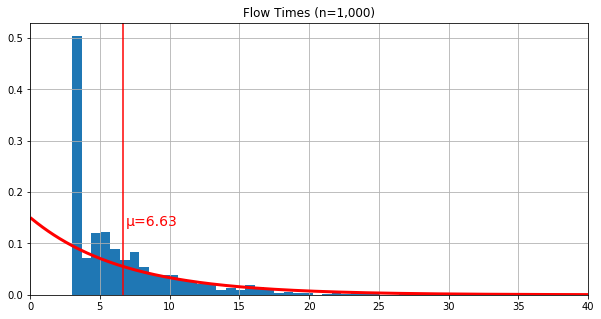

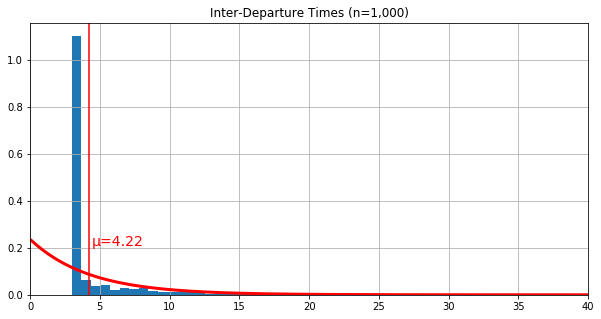

In [5]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MD1(4,3,1000, log=True, plot=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

   actual / expected   N=10,000
a=   4.00     4.00   (Inter Arrival Time)
p=   3.00     3.00   (Processing Time)
ρ=  75.0%    75.0%   (System Utilisation)
L=   1.87     1.88   (inventory in the system)
Lq=  1.12     1.12   (inventory in the queue)
Ls=  0.75     0.75   (inventory in service)
W=   7.49     7.50   (Flow Time through the System
Wq=  4.49     4.50   (Wait Time)
Ws=  3.00     3.00   (Service Time)

Max Wq= 40.38  
Max Lq= 14  


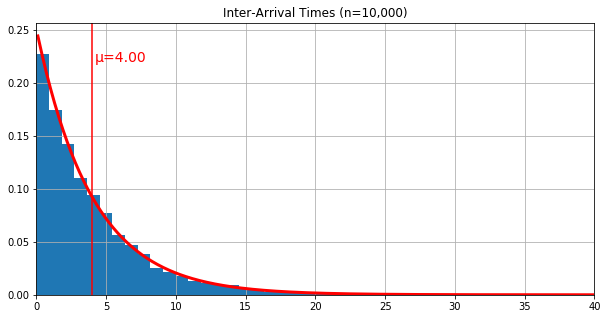

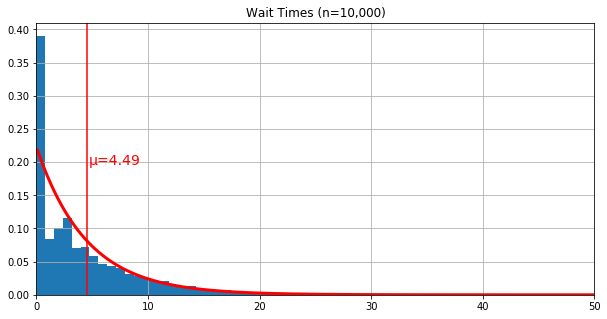

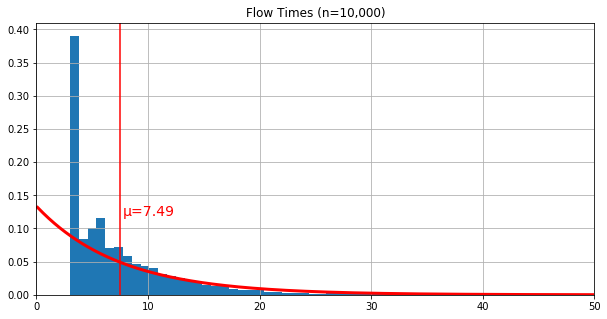

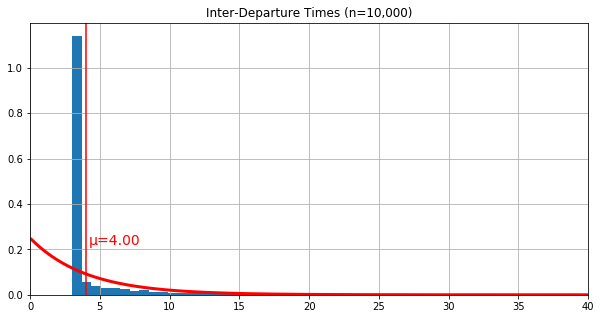

In [6]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MD1(4,3,10000, log=True, plot=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

# References

- [python math library]( https://docs.python.org/3/library/math.html)
- [matplotlib](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html)
- [pandas](https://pandas.pydata.org/pandas-docs/stable/)
- [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
- [simpy](https://simpy.readthedocs.io/en/latest/contents.html) 
    [.pdf](https://readthedocs.org/projects/simpy/downloads/pdf/latest/)
- [M/D/1](https://en.wikipedia.org/wiki/M/D/1_queue)   